### 仿射变换概念
OpenCV 中的仿射变换可以实现图像的平移（transition）、缩放（scale）、旋转（rotation）、错切（shear）等操作，仿射变换是一系列**线性变换**，因此，实际实现的时候采用的是矩阵乘法的形式。  

### 放射变换的实现原理
平面仿射变换的自由度为3（原点、基向量i，基向量j），因此 OpenCV 中仿射变换的调用接口执行下面两步：  
    `M = cv2.getAffineTransform(pts1, pts2)  # 使用 3 组对应点构造仿射变换矩阵。 `  
    `cv2.warpAffine（image, M, ...）`

### 姿态估计中的预处理
自顶向下的姿态估计方法可以分为四个步骤，第一步得到人体目标的包围框；第二步根据包围框位置进行预处理操作，得到固定尺寸的图像输入；第三步将图片输入神经网络计算姿态坐标；第四步将坐标对应到原始图像上。  
预处理操作首先将 bbox 保持宽高比缩放，然后扩充边界，使得图像变为固定大小。第四步将预处理的步骤逆向执行。上述步骤中的缩放和原点转移都属于仿射变换，因此使用仿射变换实现预处理流程是很方便的，并且可以直接用逆矩阵实现关键点的坐标转换。

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
def imshow(image):
    im = image.copy()
    im = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
    plt.imshow(im,cmap='gray')
    plt.show()

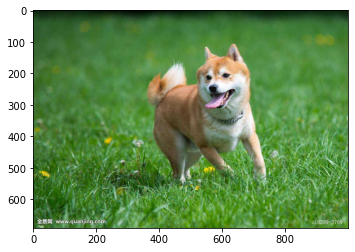

In [3]:
image = cv2.imread('dog.jpg')
imshow(image)

In [4]:
# 定义图片中柴犬的位置，以及预期输出变换后图片大小
bbox = [(351, 100), (747, 574)]
output_size = (200, 320)

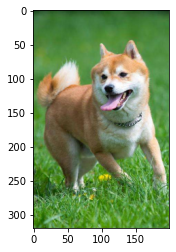

In [5]:
def get_transform(image, bbox, output_size, scale=1, inv=False, tight_box=False):
    '''
    Params:
        scale: shrink or expand bbox
        inv:   
            False: tranform from origin image to cropped image
            True:  tranform keypoint coordinate to origin image
        tight_box:
            if true, pixels outside bbox will be masked
    '''
    width, height = output_size
    aspect_ratio = width/height
    
    p1, p2 = np.array(bbox, dtype=np.float32)
    bbox_w, bbox_h = p2 - p1
    center = (p1 + p2)/2
    
    if bbox_w < aspect_ratio*bbox_h:
        extend_w = aspect_ratio*bbox_h
        if tight_box:
            for i in range(int(extend_w/2), int(bbox_w/2), -1):
                if center[0]-i >= 0:
                    image[:, int(center[0]-i)] = 0
                if center[0]+i < image.shape[1]:
                    image[:, int(center[0]+i)] = 0
        bbox_wh = np.array([extend_w, bbox_h], dtype=np.float32)
    elif bbox_h < bbox_w/aspect_ratio:
        extend_h = bbox_w/aspect_ratio
        if tight_box:
            for i in range(int(extend_h/2), int(bbox_h/2), -1):
                if center[1]-i >= 0:
                    image[int(center[1]-i), :] = 0
                if center[1]+i < image.shape[0]:
                    image[int(center[1]+i), :] = 0
        bbox_wh = np.array([bbox_w, extend_h], dtype=np.float32)
    bbox_wh *= scale
    
    src_pts = np.array([
        center - bbox_wh/2,
        [ center[0]-bbox_wh[0]/2, center[1]+bbox_wh[1]/2 ],
        center + bbox_wh/2,
    ], dtype=np.float32)
    dst_pts = np.array([
        [0, 0],
        [0, height],
        [width, height]
    ], dtype=np.float32)
    
    if not inv:
        trans = cv2.getAffineTransform(src_pts, dst_pts)
    else:
        trans = cv2.getAffineTransform(dst_pts, src_pts)
    return trans


# 经过仿射变换后，即可得到固定尺寸的目标包围框
im = image.copy()
trans = get_transform(im, bbox, output_size)
output = cv2.warpAffine(
    im,
    trans,
    output_size,
    flags=cv2.INTER_LINEAR)
imshow(output)

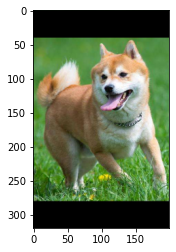

In [6]:
# 设置 tight_box 可以 mask 包围框之外的区域
im = image.copy()
trans = get_transform(im, bbox, output_size, tight_box=True)
output = cv2.warpAffine(
    im,
    trans,
    output_size,
    flags=cv2.INTER_LINEAR)
imshow(output)

In [7]:
# 在变换后的图片上定义一个关键点，如图片的中心
bbox_center = (100, 160)

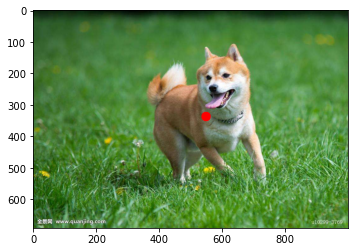

In [8]:
# 使用仿射变换的逆变换，即可将关键点的位置映射到原图
def kpt_transform(kpt, trans):
    kpt = np.array([*kpt,1]).T
    new_kpt = np.dot(trans, kpt).astype(np.int)
    return new_kpt[:2]

trans = get_transform(image, bbox, output_size, inv=True)
kpt = kpt_transform(bbox_center, trans)
cv2.circle(image, tuple(kpt), 15, (0,0,255), -1)
imshow(image)